# Decision Tree Classifier

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns

from sklearn.pipeline import make_pipeline

In [42]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

NUMBER_SEED = 1

In [43]:
df = pd.read_csv(data)

In [44]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [45]:
# drop customerID column
df = df.drop('customerID', axis=1)

In [46]:
# replace column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# replace categorical column values to lowercase and replace spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [48]:
# convert totalcharges to numeric
# parameter errors='coerce' will replace non-numeric values with NaN
#           errors='raise' (default) if any invalid value, it will raise an exception
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [49]:
# check for missing values
df.isna().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [50]:
# all columns except totalcharges have no missing values
# fill na with 0 in column totalcharges
df.totalcharges = df.totalcharges.fillna(0)

In [51]:
# target value is churn column
# change churn to number, 1 if yes, 0 if no
df.churn = (df.churn == 'yes').astype(int)

In [52]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [53]:
# split data into train, val and test 60%, 20%, 20%

# test size 20%
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=NUMBER_SEED,
    stratify=df.churn
)

# val 25% of the remaining 80% = 20%
# train is remaining 60%
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=NUMBER_SEED,
    stratify=df_full_train.churn
)

In [54]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [55]:
# separate target value and remove it from dataframes
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [56]:
# vectorize dataframes
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [57]:
# visualize a decision tree with max_depth=1

dt = DecisionTreeClassifier(max_depth=1, random_state=NUMBER_SEED)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- contract=month-to-month <= 0.50
|   |--- class: 0
|--- contract=month-to-month >  0.50
|   |--- class: 0



In [58]:

def train_dt(xt, yt, max_depth, print_tree=False, class_weight=None, min_sample_leaf=1):
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=NUMBER_SEED, class_weight=class_weight, min_samples_leaf=min_sample_leaf)
    dt.fit(xt, yt)

    if print_tree:
        print(export_text(dt, feature_names=list(dv.get_feature_names_out())))
    return dt


In [59]:
# visualize a decision tree with max_depth=2
train_dt(X_train, y_train, 2, print_tree=True)

|--- contract=month-to-month <= 0.50
|   |--- internetservice=fiber_optic <= 0.50
|   |   |--- class: 0
|   |--- internetservice=fiber_optic >  0.50
|   |   |--- class: 0
|--- contract=month-to-month >  0.50
|   |--- internetservice=fiber_optic <= 0.50
|   |   |--- class: 0
|   |--- internetservice=fiber_optic >  0.50
|   |   |--- class: 1



DecisionTreeClassifier(max_depth=2, random_state=1)

In [60]:
# visualize a decision tree with max_depth=3
train_dt(X_train, y_train, 3, print_tree=True)

|--- contract=month-to-month <= 0.50
|   |--- internetservice=fiber_optic <= 0.50
|   |   |--- contract=one_year <= 0.50
|   |   |   |--- class: 0
|   |   |--- contract=one_year >  0.50
|   |   |   |--- class: 0
|   |--- internetservice=fiber_optic >  0.50
|   |   |--- contract=one_year <= 0.50
|   |   |   |--- class: 0
|   |   |--- contract=one_year >  0.50
|   |   |   |--- class: 0
|--- contract=month-to-month >  0.50
|   |--- internetservice=fiber_optic <= 0.50
|   |   |--- tenure <= 3.50
|   |   |   |--- class: 0
|   |   |--- tenure >  3.50
|   |   |   |--- class: 0
|   |--- internetservice=fiber_optic >  0.50
|   |   |--- tenure <= 13.50
|   |   |   |--- class: 1
|   |   |--- tenure >  13.50
|   |   |   |--- class: 0



DecisionTreeClassifier(max_depth=3, random_state=1)

In [61]:
arr_max_depth = [1,2,3,4,5, 6, 7, 8]

metric_results = []

for max_depth in arr_max_depth:
    dt = train_dt(X_train, y_train, max_depth)

    y_val_pred = dt.predict_proba(X_val)[:, 1]
    #print(y_val_pred)
    y_val_pred_th = (y_val_pred >= 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred_th)
    #print(f'max_depth={max_depth} accuracy={accuracy}')

    cf = confusion_matrix(y_val, y_val_pred_th)
    tn, fp, fn, tp = cf.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # true negative rate (specificity)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # false negative rate (miss rate)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    #print(f'precision={precision}')
    #print(f'recall={recall}')
    #print(f'true_positive_rate={recall}')
    #print(f'true_negative_rate={tnr}')
    #print(f'f1={f1}')

    auc_score = roc_auc_score(y_val, y_val_pred)
    #print(f'max_depth={max_depth} auc={auc_score}')

    #print('---')
    #print('')

    # Store metrics in dictionary
    metrics = {
        'max_depth': max_depth,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'true_positive_rate': recall,
        'true_negative_rate': tnr,
        'false_negative_rate': fnr,
        'f1': f1,
        'auc': auc_score
    }
    metric_results.append(metrics)

    #break


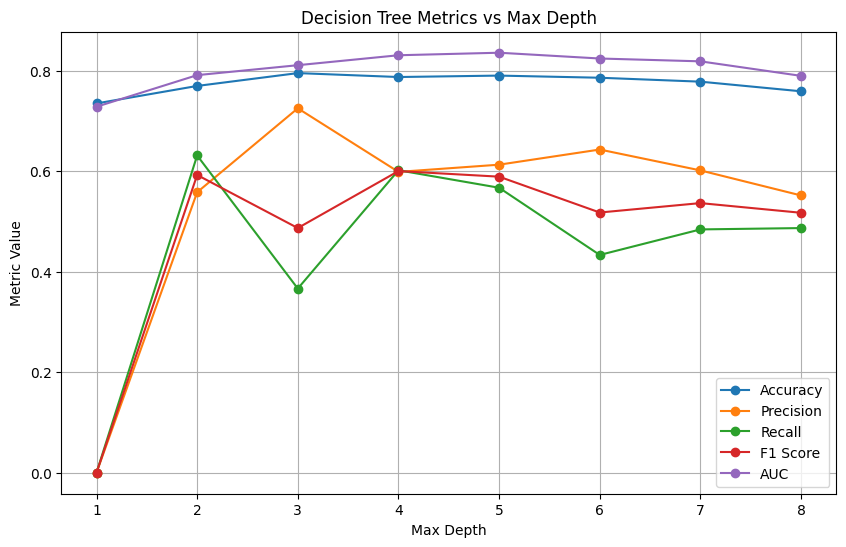

In [62]:
# plot metrics result
df_metrics = pd.DataFrame(metric_results)
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['max_depth'], df_metrics['accuracy'], marker='o', label='Accuracy')
plt.plot(df_metrics['max_depth'], df_metrics['precision'], marker='o', label='Precision')
plt.plot(df_metrics['max_depth'], df_metrics['recall'], marker='o', label='Recall')
plt.plot(df_metrics['max_depth'], df_metrics['f1'], marker='o', label='F1 Score')
plt.plot(df_metrics['max_depth'], df_metrics['auc'], marker='o', label='AUC')
plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.title('Decision Tree Metrics vs Max Depth')
plt.legend()
plt.grid()
plt.show()

Try combination parameter max_depth and min_sample_leaf

In [63]:
scores = []

for max_depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = train_dt(X_train, y_train, max_depth, min_sample_leaf=s)
        y_val_pred = dt.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_val_pred)

        scores.append((max_depth, s, auc_score))

In [64]:
columns = ['max_depth', 'min_samples_leaf', 'auc_score']
df_scores = pd.DataFrame(scores, columns=columns)

In [65]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc_score'])
#df_scores_pivot.round(3)

In [66]:
df_scores

,max_depth,min_samples_leaf,auc_score
0,4,1,0.830383
1,4,5,0.830383
2,4,10,0.830383
3,4,15,0.830383
4,4,20,0.830383
5,4,500,0.816708
6,4,100,0.827935
7,4,200,0.826597
8,5,1,0.835417
9,5,5,0.833785


In [67]:
df_scores_pivot

auc_score                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.830383  0.835417  0.823901
5                 0.830383  0.833785  0.822181
10                0.830383  0.835266  0.822754
15                0.830383  0.835852  0.824374
20                0.830383  0.837927  0.826282
100               0.827935  0.829773  0.834653
200               0.826597  0.826738  0.826738
500               0.816708  0.816708  0.816708

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

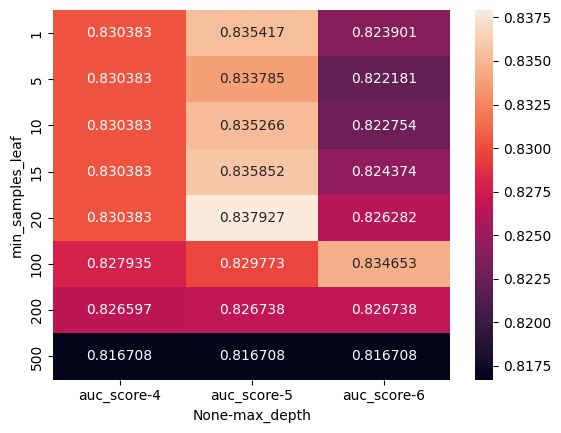

In [68]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".6f")

Base on the heatmap, choose max_depth=5 and min_sample_leaf=5, it give highest auc 0.8329370083924655

## Cross validation with kfold

In [69]:
# combine train + val
#X_full_train = np.vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

In [70]:
# do cross validation

# convert arr_param to array of dict for readability
arr_param = [
    {'min_samples_leaf': 10, 'max_depth': 4},
    {'min_samples_leaf': 5, 'max_depth': 5},
    {'min_samples_leaf': 10, 'max_depth': 6}
]

# Rebuild full-train raw dicts so the DictVectorizer can be fit inside each fold
df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

result_auc = []

for p in arr_param:
    #print(p)

    pipe = make_pipeline(
        DictVectorizer(sparse=False),
        DecisionTreeClassifier(max_depth=p['max_depth'], min_samples_leaf=p['min_samples_leaf'], random_state=NUMBER_SEED)
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=NUMBER_SEED)
    auc_scores = cross_val_score(pipe, X_full_train_dict, y_full_train, cv=cv, scoring='roc_auc')
    auc_mean = auc_scores.mean()
    auc_std = auc_scores.std()
    result_auc.append((p['max_depth'], p['min_samples_leaf'], auc_mean, auc_std))



In [71]:
# Print result_auc in a table format
df_result_auc = pd.DataFrame(result_auc, columns=['max_depth', 'min_samples_leaf','auc_mean', 'auc_std'])
print(df_result_auc)

   max_depth  min_samples_leaf  auc_mean   auc_std
0          4                10  0.831390  0.005438
1          5                 5  0.831681  0.009425
2          6                10  0.825921  0.006799


From cross validation result, it confirm that option max_depth=5 and min_samples_leaf=5, have the highest mean.



## Train final model

Train final model with train+val dataset, using parameter max_depth=5 and min_samples_leaf=5.

And do prediction using test dataset.

In [72]:
# Final model using the same pipeline approach
final_pipe = make_pipeline(
    DictVectorizer(sparse=False),
    DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=NUMBER_SEED)
)

df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

final_pipe.fit(X_full_train_dict, y_full_train)


Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        random_state=1))])

In [73]:
# Predict on test
X_test_dict = df_test.to_dict(orient='records')
y_test_pred = final_pipe.predict_proba(X_test_dict)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred)

print("auc test ",auc_test)

auc test  0.8232116562039836


Get top 10 Feature Importance

In [74]:
# Extract feature names and importances from the fitted pipeline
dv_final = final_pipe.named_steps['dictvectorizer']
tree_final = final_pipe.named_steps['decisiontreeclassifier']

df_fi = pd.DataFrame({
    'feature': dv_final.get_feature_names_out(),
    'importance': tree_final.feature_importances_
}).sort_values(by='importance', ascending=False)

# Top 10
df_fi.head(10)

,feature,importance
0,contract=month-to-month,0.507785
43,tenure,0.174668
11,internetservice=fiber_optic,0.157280
13,monthlycharges,0.039457
44,totalcharges,0.032643
40,techsupport=no,0.028317
29,paymentmethod=electronic_check,0.023722
17,onlinebackup=no,0.012385
1,contract=one_year,0.010690
20,onlinesecurity=no,0.004330


Plot ROC curve on test dataset

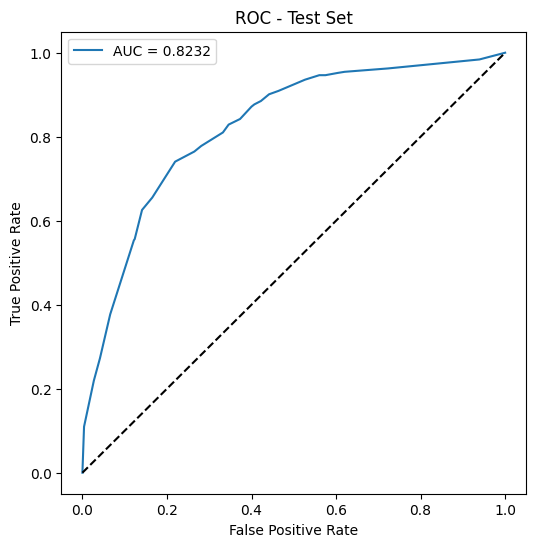

In [75]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend()
plt.show()
